<img src="figures/logos.png" style="float: centre;" width="800"/>

# Coseismic practical

## Written for the COMET InSAR Workshop 2022.

Welcome to this COMET practical on coseismic deformation signals in InSAR.

This practical has been tested on the latest versons of Chrome and Firefox, but should work in most modern browsers.

### Interacting with this practical

To run a cell containing code, you can either press "Run" in the bar above, or press "Shift+Enter".

A "#" indicates a comment within the code. 

##################################### <br />
Blocks of code surrounded by multiple "#" (like this one) indicate variables that you can experiment changing the values to. While you can experiment with the full body of code further (and I encourage you to do so after the course), we are limited in our ability to help you debug any errors you may encounter. Changing just the values indicate should result in no major errors. <br />
#####################################

If you get a "dead kernel" error, either restart the kernel under "Kernel" on the top bar, or reopen the binder fresh. None of your changes here will affect the original binder, so feel free to reload it if anything breaks.

### Acknowledgements
This notebook was written using resources from the Tectonophysics ([Tim Wright](https://environment.leeds.ac.uk/see/staff/1613/professor-tim-wright)) undergraduate modules at the University of Leeds, with advice from [John Elliott](https://environment.leeds.ac.uk/see/staff/1248/dr-john-elliott).

[Andrew Watson](https://environment.leeds.ac.uk/see/pgr/2311/andrew-watson) - 2022

In [1]:
# Import required modules. Run this before continuing.

# this is our own library of functions, which can be found in the same directory as this notebook
import coseis_lib as lib

# for running and plotting the models
import numpy as np
import matplotlib.pyplot as plt

# this is additional scientific colour maps, see "https://www.fabiocrameri.ch/colourmaps/"
from cmcrameri import cm

<module 'coseis_lib' from '/nfs/a285/homes/eearw/demonstrating/coseismic_practical/coseis_lib.py'>

## 0. Introduction

Since the launch of ERS-1 in 1991, the coseismic displacements of more than 100 earthquakes have been captured by InSAR. These range in size from Magnitude ~5 to Magnitude ~8, and have a variety of different mechanisms. Typically, coseismic interferograms are interpreted by comparing the interferograms with the predictions of elastic dislocation models, in which slip occurs on one or more dislocations (fault) in an elastic half space.

We'll be working with the model of Okada (1985), with uniform slip occuring on a rectangular dislocation in an elastic half-space. Figure 1 shows a schematic diagram of the model, including the parameters that you will be able to vary throughout the practical.

<img src="figures/okada_half_space.png" style="float: centre;" width="800"/>
*Figure 1: Schematic diagram of the Okada half space model used in this practical.*

In this practical, you will:

**1)** Produce synthetic displacement maps for strike-slip and normal faulting earthquakes, so as to investigate the underlying structure of the deformation signals produced by different earthquake mechanisms when observed through InSAR.

**2)** Fit a forward model to the March 2021, $M_w$ 6.3 Thessaly Mainshock in Greece.

**3)** Fit a forward model to the June 2022, $M_w$ 6.0 Afghanistan earthquake.

**4)** Fit a forward model to the November 2017, $M_w$ 7.3 Sarpol-e Zahab earthquake in Iran,.


For each of these earthquakes, you will try to find a simple, single-fault model that provides a reasonable fit to the observed interferograms.

By the end of this practical, you should have an improved understanding of how to interpret coseismic interferograms, understand how to produce elastic dislocation models of earthquakes, and better appricate the uncertainties involved with determining earthquake mechanisms from coseismic InSAR data.

*Okada, Y. (1985). Surface deformation due to shear and tensile faults in a half-space. Bulletin of the seismological society of America, 75(4), 1135-1154.*

## 1. Simple synthetics

We'll begin with some simple synethetic models to help you understand how different earthquake mechanisms appear in InSAR.

In [2]:
# Define the coordinate grid and elastic parameters for our models.

# dimensions of grid in x (m)
xmin, xmax, xint = -30000, 30000, 100

# dimensions of grid in y (m)
ymin, ymax, yint = -30000, 30000, 100

# create coordinate grids
x = np.arange(xmin, xmax, xint)
y = np.arange(ymin, ymax, yint)
xx, yy = np.meshgrid(x, y)

# convert to pair of coordinates for our dislocation model
xx_vec = np.reshape(xx, -1)
yy_vec = np.reshape(yy, -1)

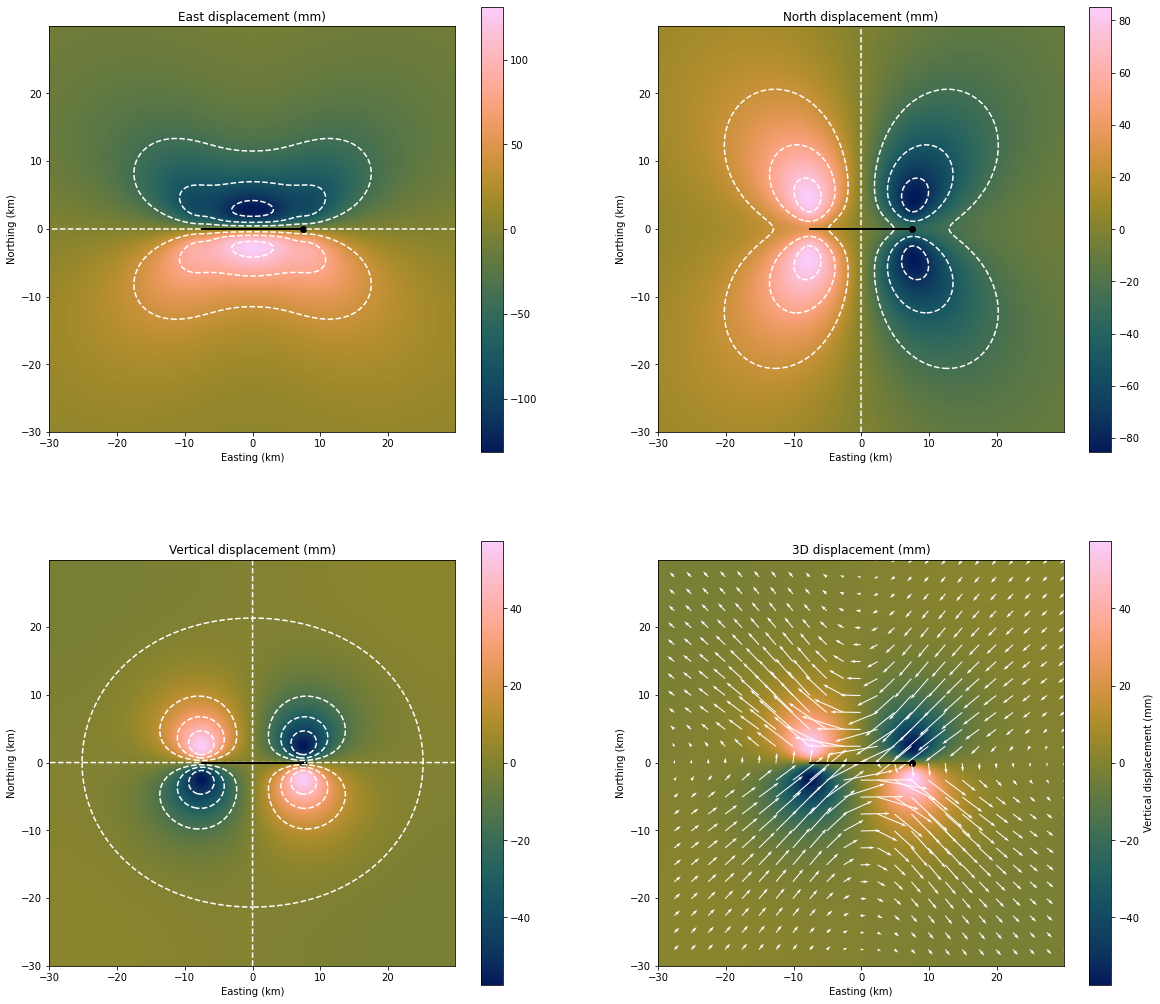

In [3]:
# Generate and plot a simple strike-slip model

# Define the fault model
#####################################
xcen = 0          # vertical surface projection of fault centroid in x (m)
ycen = 0          # vertical surface projection of fault centroid in y (m)
strike = 90        # strike in degrees (0-360)
dip =    90         # dip in degrees (0-90)
rake =   0        # rake in degrees (-180 - 180)
slip =     1        # magnitude of slip vector in metres
centroid_depth = 6000       # depth (measured vertically) to fault centroid in metres
width = 8000    # width of fault measured along-dip in metres
length =  15000        # fault length in metres
#####################################

model = [xcen, ycen, strike, dip, rake, slip, length, centroid_depth, width]

# Calcualte displacements
disp = lib.disloc3d3(xx_vec, yy_vec, xoff=xcen, yoff=ycen, depth=centroid_depth,
                  length=length, width=width, slip=slip, opening=0, 
                   strike=strike, dip=dip, rake=rake, nu=0.25)

# Plot the three components of displacement
lib.plot_enu(disp, model, x, y)

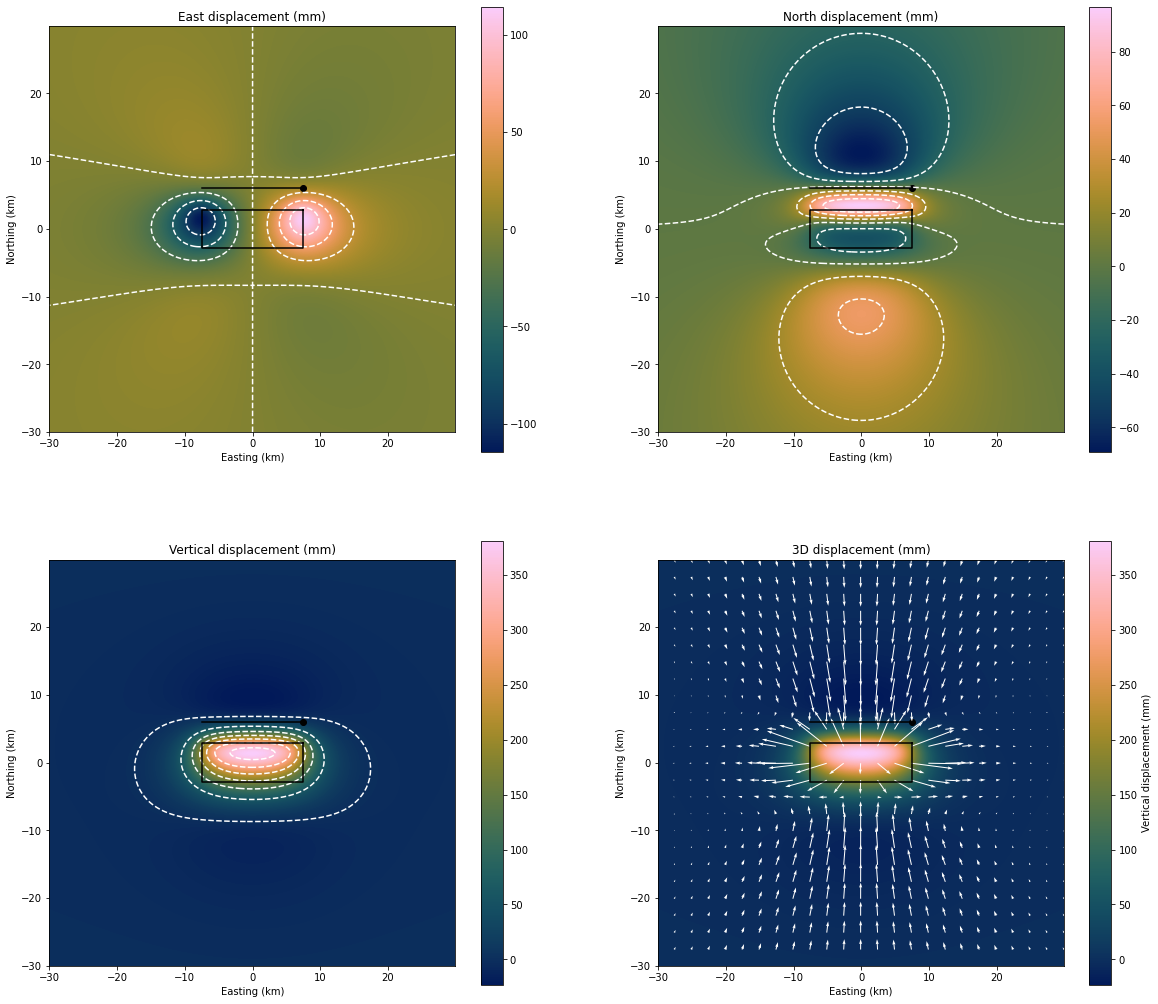

In [4]:
# Same again but for a thrust fault

# Define the fault model
#####################################
xcen = 0          # vertical surface projection of fault centroid in x (m)
ycen = 0          # vertical surface projection of fault centroid in y (m)
strike = 90        # strike in degrees (0-360)
dip =    45         # dip in degrees (0-90)
rake =   90        # rake in degrees (-180 - 180)
slip =     1        # magnitude of slip vector in metres
centroid_depth = 6000       # depth (measured vertically) to fault centroid in metres
width = 8000    # width of fault measured along-dip in metres
length =  15000        # fault length in metres
#####################################

model = [xcen, ycen, strike, dip, rake, slip, length, centroid_depth, width]

# Calcualte displacements
disp = lib.disloc3d3(xx_vec, yy_vec, xoff=xcen, yoff=ycen, depth=centroid_depth,
                  length=length, width=width, slip=slip, opening=0, 
                   strike=strike, dip=dip, rake=rake, nu=0.25)

# Plot the three components of displacement
lib.plot_enu(disp, model, x, y)

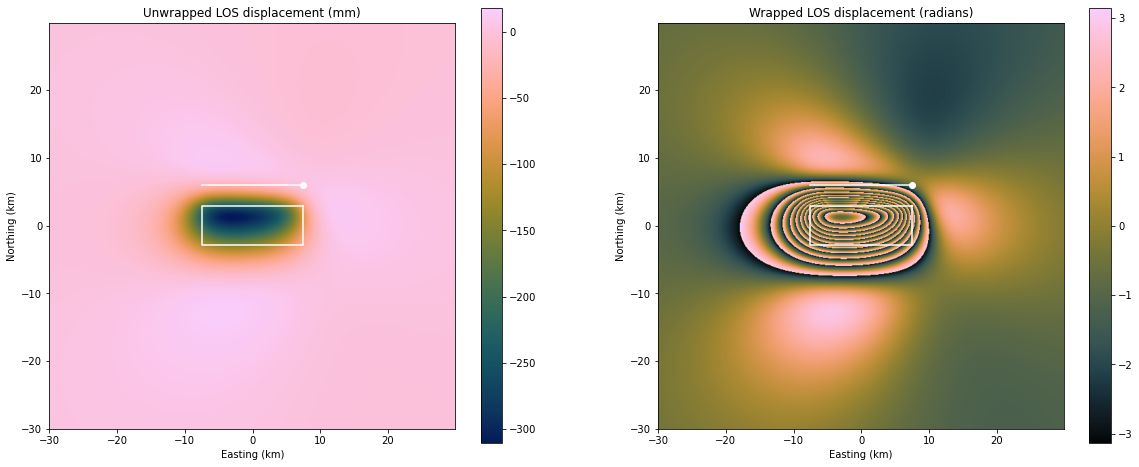

In [5]:
# Plot the same earthquake model projected into the satellite line-of-sight (LOS).
# Try an azimuth of -10° for ascending and -170° for descending.
# We will follow the convention used by LiCS, where motion away from the satellite (i.e. range increase) is positive.

# Assuming a fixed azimuth and incidence angle
#####################################
incidence_angle = 38
azimuth_angle = -10
#####################################

# Convert to unit vector components
e2los = np.cos(np.deg2rad(azimuth_angle)) * np.sin(np.deg2rad(incidence_angle))
n2los = -np.sin(np.deg2rad(azimuth_angle)) * np.sin(np.deg2rad(incidence_angle))
u2los = -np.cos(np.deg2rad(incidence_angle))
# in future, these three lines have been written into the subfunction "comp2los".

# Plot unwrapped and wrapped LOS displacements
lib.plot_los(disp, model, x, y, e2los, n2los, u2los)

## 4. Real-world example: 2021-03-03 Greece Earthquake

On 3rd March 2021, a $M_w$ 6.3 earthquake occured in the Thessaly plain, central Greece (Kontoes et al. 2022). This was followed by a $M_w$ 6.0 event on the 4th, and a $M_w$ 5.2 event on the 12th.

The provided interferogram from track 102A, spanning 2021-02-18 to 2021-03-03, captures surfaces displacement from the $M_w$ 6.3 mainshock. This interferogram, along with others showing coseismic displacement, can be found at:
https://comet.nerc.ac.uk/earthquakes/us7000df40.html

I have converted the coordinates from latitude-longitude to UTM, since our modelling assumes distances in metres, and centred the coords within the interferogram to make it easier to work with.

*Kontoes, C., Alatza, S., Chousianitis, K., Svigkas, N., Loupasakis, C., Atzori, S., & Apostolakis, A. (2022). Coseismic Surface Deformation, Fault Modeling, and Coulomb Stress Changes of the March 2021 Thessaly, Greece, Earthquake Sequence Based on InSAR and GPS Data. Seismological Society of America, 93(5), 2584-2598.*

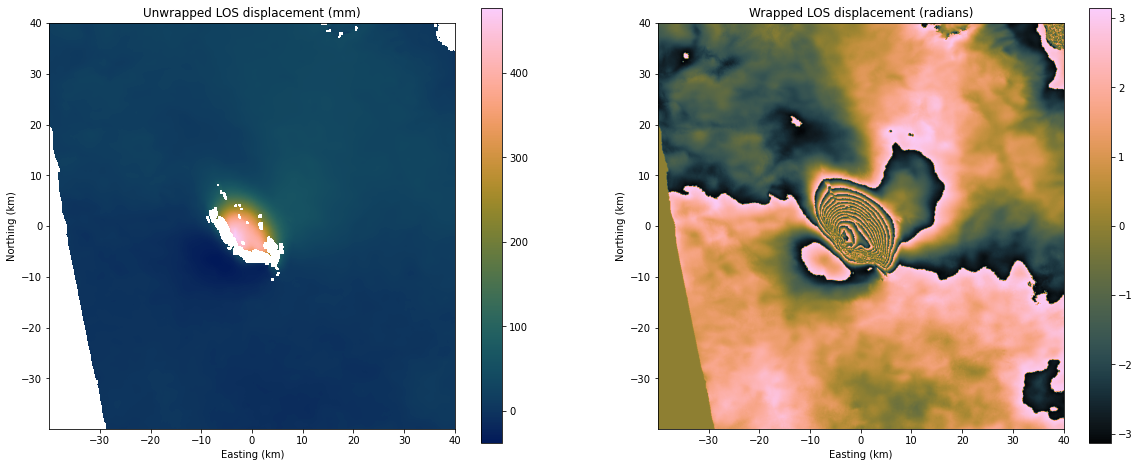

In [6]:
# Begin by loading and plotting the interferogram.

# load ifgs for this example
x, y, greece_unw, greece_diff = lib.load_ifgs('greece')

# Setup plot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
extent = (x[0]/1000, x[-1]/1000, y[0]/1000, y[-1]/1000)

# Plot unwrapped
im_u = ax[0].imshow(greece_unw*1000, extent=extent, origin='lower', cmap=cm.batlow)
fig.colorbar(im_u, ax=ax[0])
ax[0].set_xlabel('Easting (km)')
ax[0].set_ylabel('Northing (km)')
ax[0].set_title('Unwrapped LOS displacement (mm)')

# Plot wrapped
im_w = ax[1].imshow(greece_diff, extent=extent, origin='lower', cmap=cm.batlowK)
fig.colorbar(im_w, ax=ax[1])
ax[1].set_xlabel('Easting (km)')
ax[1].set_ylabel('Northing (km)')
ax[1].set_title('Wrapped LOS displacement (radians)')

plt.show()

Estimated seismic moment = 2.4e+18 Nm
Estimated moment magnitude = 6.22
RMS misfit between data and model = 46.35 mm


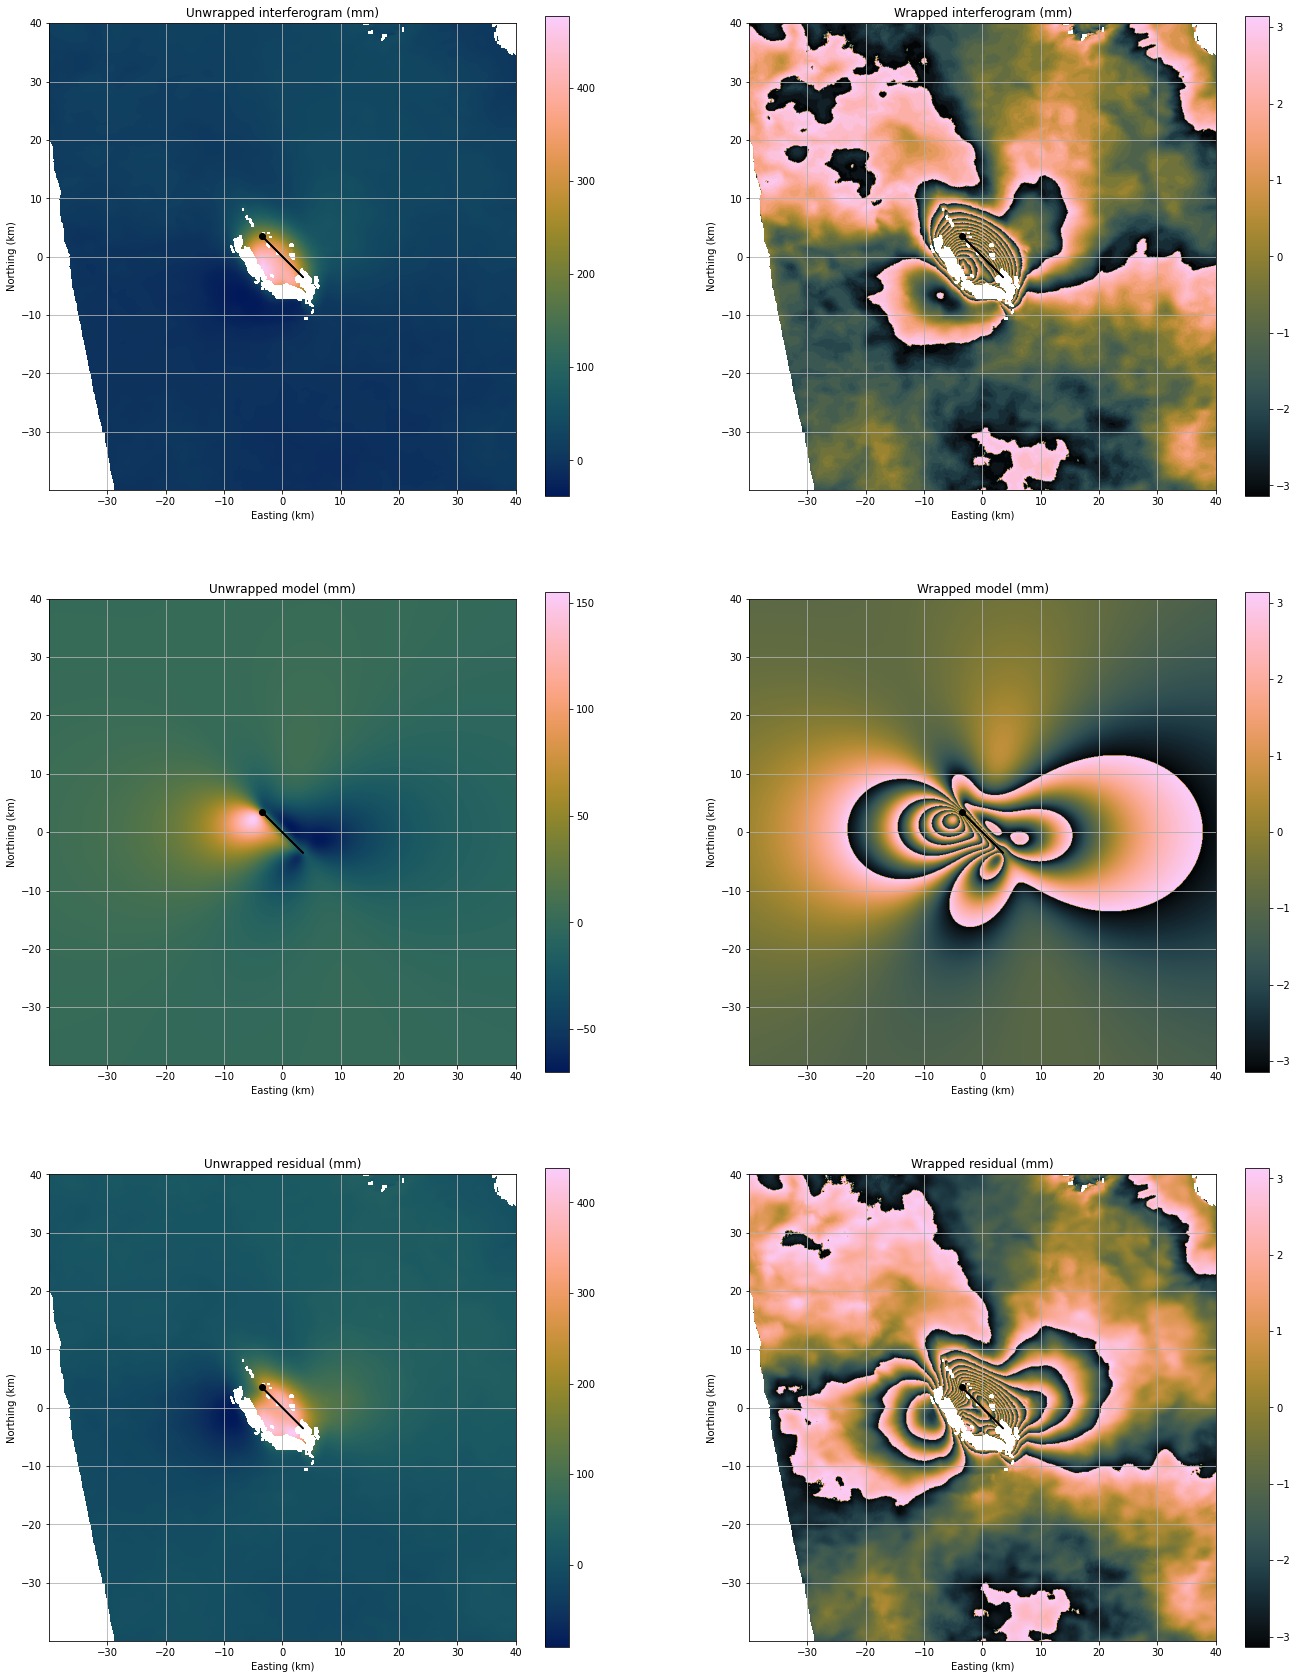

In [7]:
# Assuming a fixed azimuth and incidence angle
#####################################
incidence_angle = 45
azimuth_angle = -10
#####################################
importlib.reload(lib)
# Define the fault model
#####################################
xcen = 0          # vertical surface projection of fault centroid in x (m)
ycen = 0          # vertical surface projection of fault centroid in y (m)
strike = 315        # strike in degrees (0-360)
dip =    90         # dip in degrees (0-90)
rake =   0        # rake in degrees (-180 - 180)
slip =     1        # magnitude of slip vector in metres
centroid_depth = 5 * 1e3       # depth (measured vertically) to fault centroid in metres
width = 8 * 1e3    # width of fault measured along-dip in metres
length =  10 * 1e3        # fault length in metres
#####################################

model = [xcen, ycen, strike, dip, rake, slip, length, centroid_depth, width]

# We'll use the same vectors of coordinates as the interferogram
xx, yy = np.meshgrid(x, y)

# convert to vectors for our dislocation model
xx_vec = np.reshape(xx, -1)
yy_vec = np.reshape(yy, -1)

# Generate to unit vector components
e2los, n2los, u2los = lib.comp2los(azimuth_angle, incidence_angle)

# Calcualte displacements
disp = lib.disloc3d3(xx_vec, yy_vec, xoff=xcen, yoff=ycen, depth=centroid_depth,
                  length=length, width=width, slip=slip, opening=0, 
                   strike=strike, dip=dip, rake=rake, nu=0.25)

# Plot comparison
lib.plot_data_model(x, y, disp, model, greece_unw, e2los, n2los, u2los, show_grid=True)

## 5. Real-world example: 2022-06-01 Afghanistan Earthquake

Next, we'll look at a $M_w$ 6.0 earthquake that occured on 1st June 2022 in Eastern Afghanistan.

The provided interferogram from track 078D spans from 2022-06-19 to 2022-07-01. This interferogram, along with others showing coseismic displacement, can be found at: https://comet.nerc.ac.uk/earthquakes/us7000hj3u.html

Text(0.5, 1.0, 'Wrapped LOS displacement (radians)')

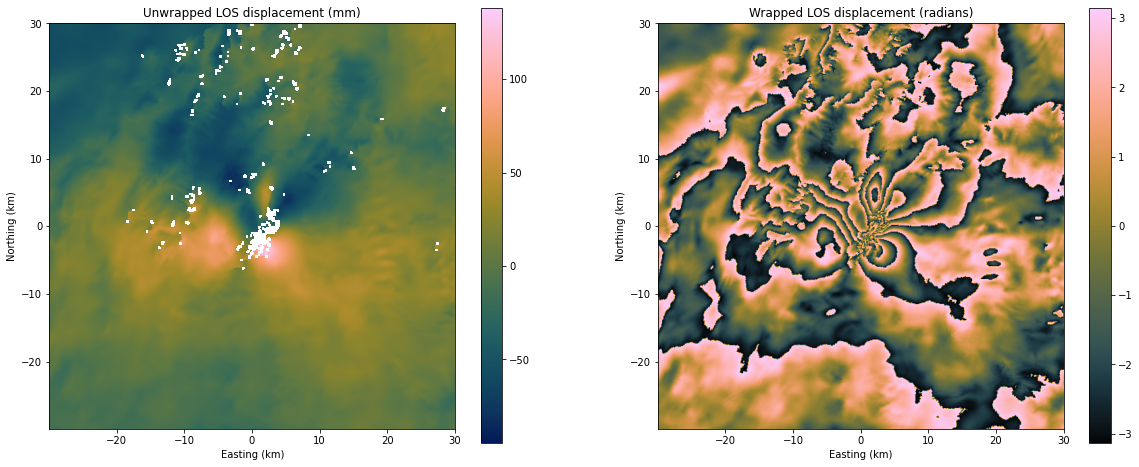

In [8]:
# Begin by loading and plotting the interferogram.

# load ifgs for this example
x, y, afghanistan_unw, afghanistan_diff = lib.load_ifgs('afghanistan')

# Setup plot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
extent = (x[0]/1000, x[-1]/1000, y[0]/1000, y[-1]/1000)

# Plot unwrapped
im_u = ax[0].imshow(afghanistan_unw*1000, extent=extent, origin='lower', cmap=cm.batlow)
fig.colorbar(im_u, ax=ax[0])
ax[0].set_xlabel('Easting (km)')
ax[0].set_ylabel('Northing (km)')
ax[0].set_title('Unwrapped LOS displacement (mm)')

# Plot wrapped
im_w = ax[1].imshow(afghanistan_diff, extent=extent, origin='lower', cmap=cm.batlowK)
fig.colorbar(im_w, ax=ax[1])
ax[1].set_xlabel('Easting (km)')
ax[1].set_ylabel('Northing (km)')
ax[1].set_title('Wrapped LOS displacement (radians)')

Estimated seismic moment = 1.5e+18 Nm
Estimated moment magnitude = 6.08
RMS misfit between data and model = 29.23 mm


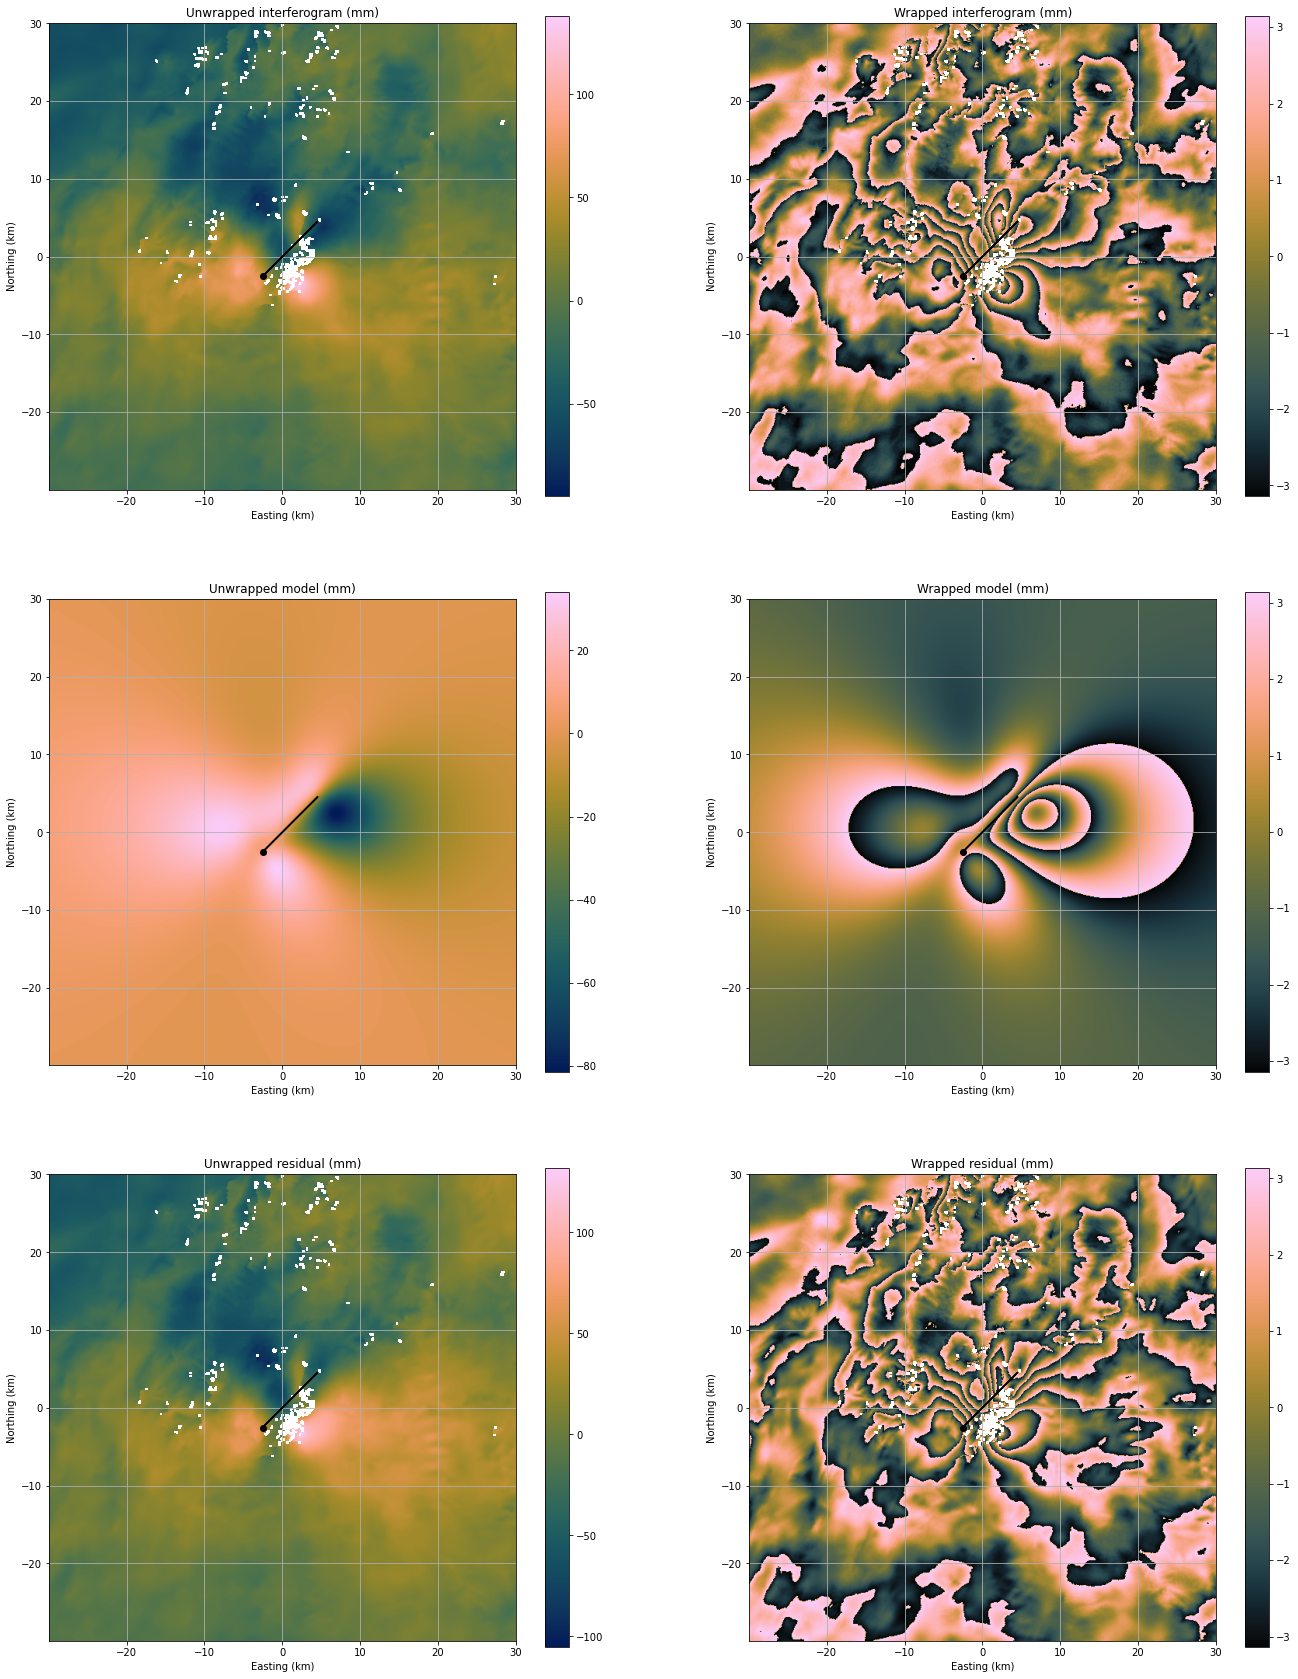

In [9]:
# Assuming a fixed azimuth and incidence angle
#####################################
incidence_angle = 45
azimuth_angle = -170
#####################################

# Define the fault model
#####################################
xcen = 1000          # vertical surface projection of fault centroid in x (m)
ycen = 1000          # vertical surface projection of fault centroid in y (m)
strike = 225        # strike in degrees (0-360)
dip =    90         # dip in degrees (0-90)
rake =   0        # rake in degrees (-180 - 180)
slip =     1        # magnitude of slip vector in metres
centroid_depth = 5.0 * 1e3       # depth (measured vertically) to fault centroid in metres
width = 5.0 * 1e3    # width of fault measured along-dip in metres
length =  10.0 * 1e3        # fault length in metres
#####################################

model = [xcen, ycen, strike, dip, rake, slip, length, centroid_depth, width]

# We'll use the same vectors of coordinates as the interferogram
xx, yy = np.meshgrid(x, y)

# convert to vectors for our dislocation model
xx_vec = np.reshape(xx, -1)
yy_vec = np.reshape(yy, -1)

# Generate to unit vector components
e2los, n2los, u2los = lib.comp2los(azimuth_angle, incidence_angle)

# Calcualte displacements
disp = lib.disloc3d3(xx_vec, yy_vec, xoff=xcen, yoff=ycen, depth=centroid_depth,
                  length=length, width=width, slip=slip, opening=0, 
                   strike=strike, dip=dip, rake=rake, nu=0.25)

# Plot comparison
lib.plot_data_model(x, y, disp, model, afghanistan_unw, e2los, n2los, u2los, show_grid=True)

## 6. Real-world example: The 2017 Sarpol-e Zahab Earthquake

Finally, we're going to look at the 12th November 2017 Sarpol-e Zahab Earthquake in Iran (Nissen et al. 2019).
The provided interferogram spans 2017-11-07 to 2017-11-19, and is part of LiCS frame "006D_05509_131313".
There is no earthquake responder page for this earthquake, as it occured before the system became active, but other coseismic interferograms can still be found on the main portal: https://comet.nerc.ac.uk/COMET-LiCS-portal/

This interferogram highlights a common problem for InSAR studies of coseismic deformation - the signal is cropped by the edge of the track. Normally, we would use multiple interferograms from different tracks and different look directions, but here we'll just see what we can model with a single track.

*Nissen, E., Ghods, A., Karasözen, E., Elliott, J. R., Barnhart, W. D., Bergman, E. A., ... & Chen, L. (2019). The 12 November 2017 M w 7.3 Ezgeleh‐Sarpolzahab (Iran) earthquake and active tectonics of the Lurestan Arc. Journal of Geophysical Research: Solid Earth, 124(2), 2124-2152.*

Text(0.5, 1.0, 'Wrapped LOS displacement (radians)')

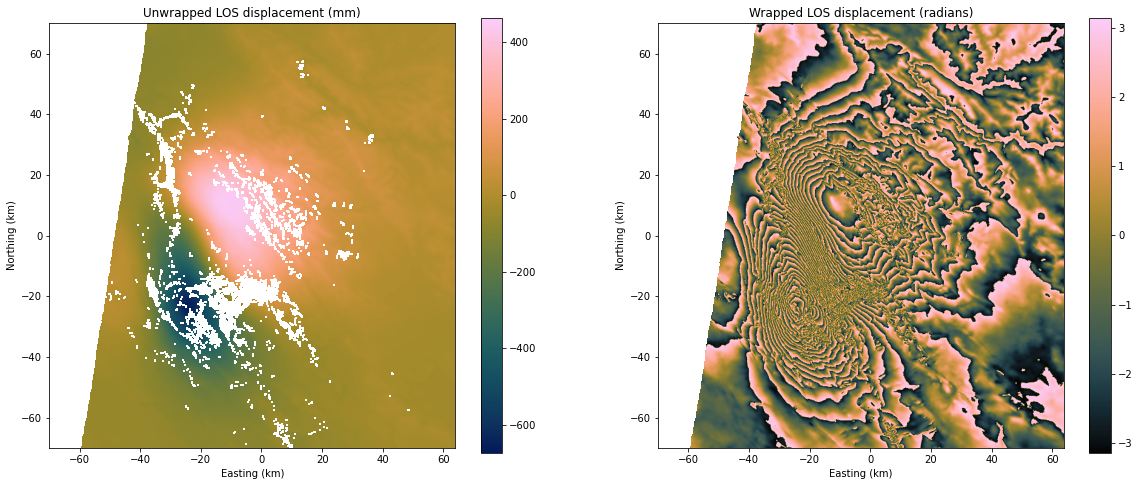

In [10]:
# Begin by loading and plotting the interferogram.
# Note - currently loading every second point (200 m) to reduce run time.
# Set downsamp=False to load every pixel (100 m).

# load ifgs for this example
x, y, sarpol_unw, sarpol_diff = lib.load_ifgs('iran', downsamp=True)

# Setup plot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
extent = (x[0]/1000, x[-1]/1000, y[0]/1000, y[-1]/1000)

# Plot unwrapped
im_u = ax[0].imshow(sarpol_unw*1000, extent=extent, origin='lower', cmap=cm.batlow)
fig.colorbar(im_u, ax=ax[0])
ax[0].set_xlabel('Easting (km)')
ax[0].set_ylabel('Northing (km)')
ax[0].set_title('Unwrapped LOS displacement (mm)')

# Plot wrapped
im_w = ax[1].imshow(sarpol_diff, extent=extent, origin='lower', cmap=cm.batlowK)
fig.colorbar(im_w, ax=ax[1])
ax[1].set_xlabel('Easting (km)')
ax[1].set_ylabel('Northing (km)')
ax[1].set_title('Wrapped LOS displacement (radians)')

Estimated seismic moment = 9e+18 Nm
Estimated moment magnitude = 6.6
RMS misfit between data and model = 138.39 mm


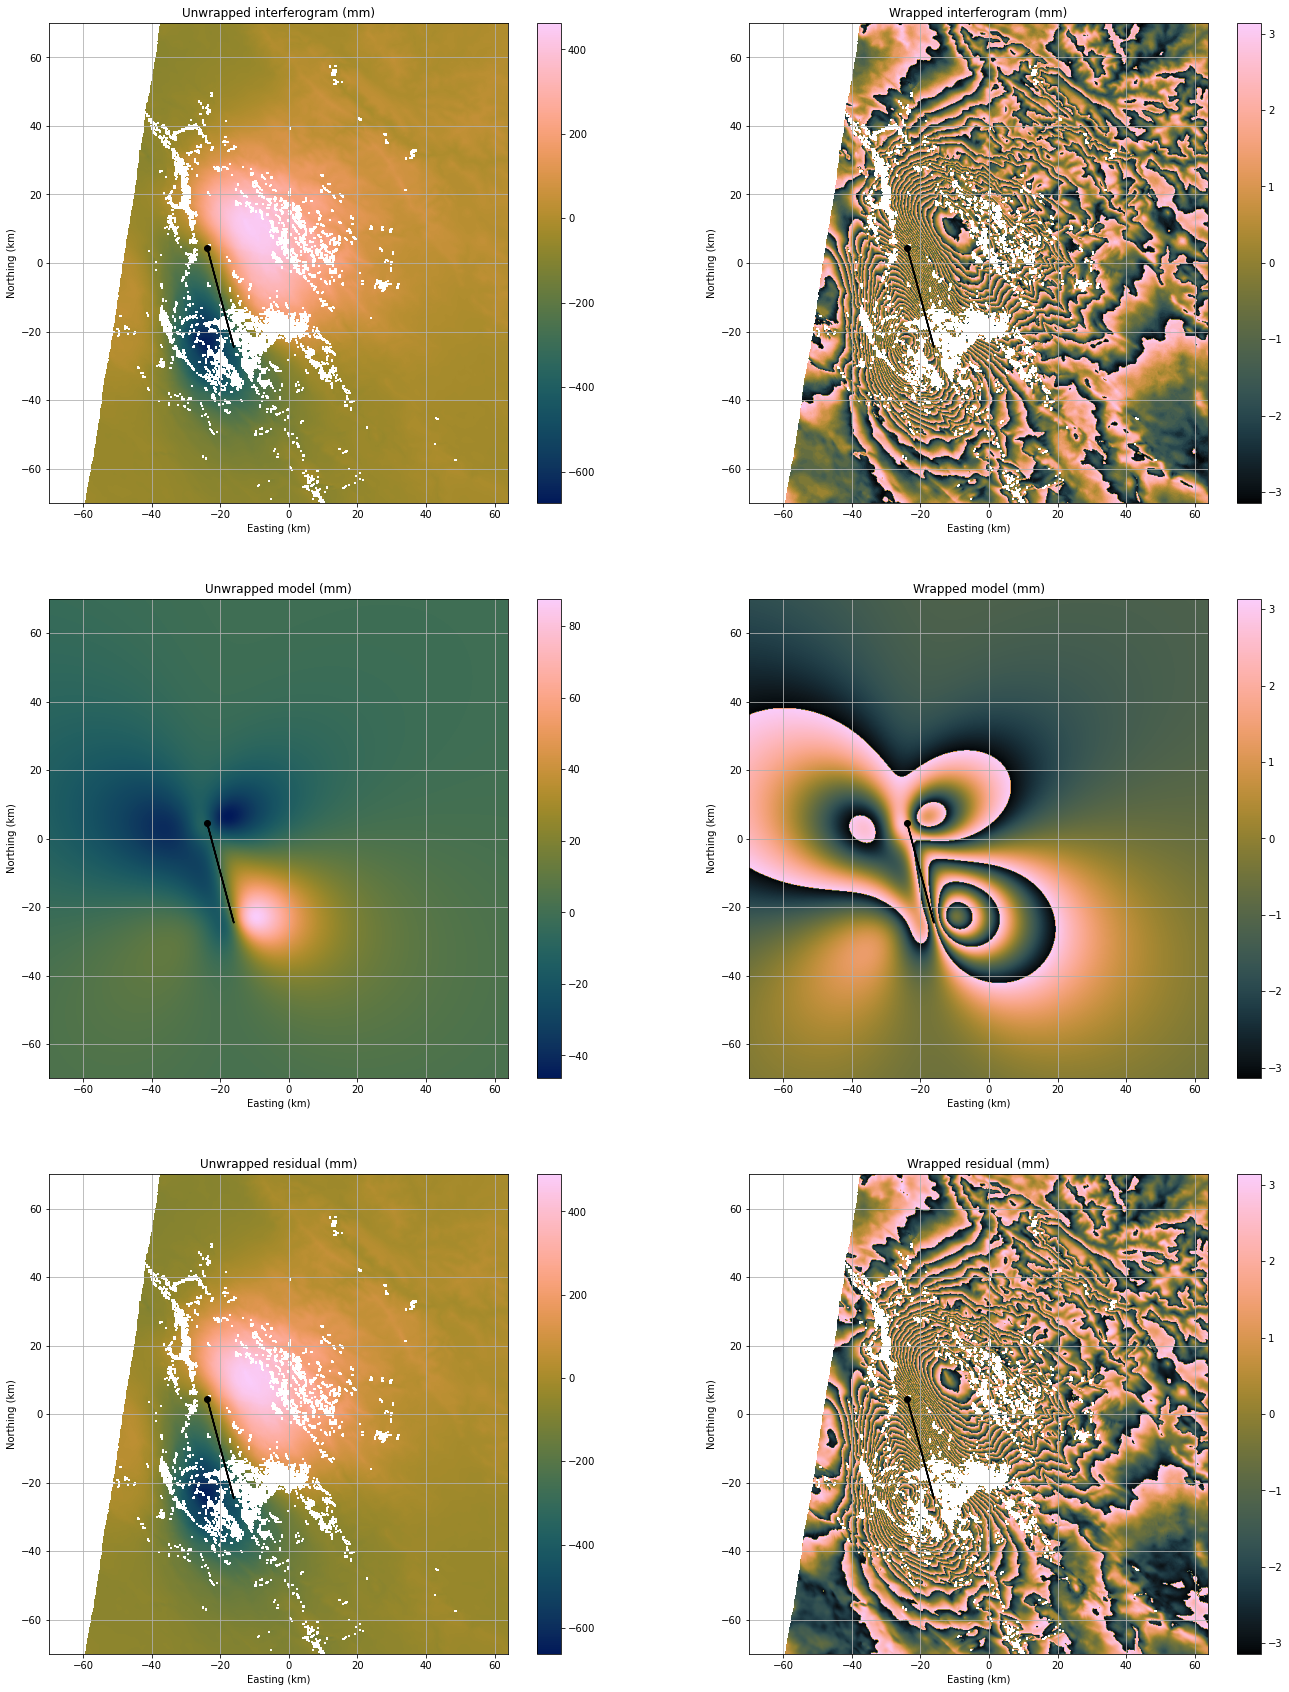

In [11]:
# Assuming a fixed azimuth and incidence angle
#####################################
incidence_angle = 45
azimuth_angle = -170
#####################################

# Define the fault model
#####################################
xcen = -20 * 1e3          # vertical surface projection of fault centroid in x (m)
ycen = -10 * 1e3          # vertical surface projection of fault centroid in y (m)
strike = 345        # strike in degrees (0-360)
dip =    90         # dip in degrees (0-90)
rake =   0        # rake in degrees (-180 - 180)
slip =     1        # magnitude of slip vector in metres
centroid_depth = 10 * 1e3       # depth (measured vertically) to fault centroid in metres
width = 10 * 1e3    # width of fault measured along-dip in metres
length =  30 * 1e3        # fault length in metres
#####################################

model = [xcen, ycen, strike, dip, rake, slip, length, centroid_depth, width]

# We'll use the same vectors of coordinates as the interferogram
xx, yy = np.meshgrid(x, y)

# convert to vectors for our dislocation model
xx_vec = np.reshape(xx, -1)
yy_vec = np.reshape(yy, -1)

# Generate to unit vector components
e2los, n2los, u2los = lib.comp2los(azimuth_angle, incidence_angle)

# Calcualte displacements
disp = lib.disloc3d3(xx_vec, yy_vec, xoff=xcen, yoff=ycen, depth=centroid_depth,
                  length=length, width=width, slip=slip, opening=0, 
                   strike=strike, dip=dip, rake=rake, nu=0.25)

# Plot comparison
lib.plot_data_model(x, y, disp, model, sarpol_unw, e2los, n2los, u2los, show_grid=True)

## Conclusion

Hopefully, you now have a better understanding of how to model coseismic dispalcement in InSAR using a uniform slip okada model. To check your model parameter results against those from published studies / USGS, run the following cell.

If you found any issues in this practical, please log them under "issues" on the github repository.

Andrew Watson - 2022

In [12]:
# Run this to print the results.
lib.print_results()


    Well done for completing the practical.
    Printed below are 'good fit' model parameters for the three examples, based on the provided source
    and with a bit of adjusting from John Elliott.
    
    Greece
    ----------------------------------------
              xcen = 150
              ycen = -150
            strike = 315
               dip = 36
              rake = -100
              slip = 1.15
    centroid depth = 4500
             width = 9400
            length = 9900
            
    Source: https://pubs.geoscienceworld.org/ssa/srl/article/93/5/2584/614110/Coseismic-Surface-Deformation-Fault-Modeling-and
    
    Afghanistan
    ----------------------------------------
              xcen = 1000
              ycen = 1000
            strike = 210
               dip = 78
              rake = 15
              slip = 1.4
    centroid depth = 2800
             width = 4000
            length = 6000
            
    Source: https://earthquake.usgs.gov/earthquakes/eventpage/u